# TF analysis for single-cell multimodal PBMC

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
from muon import atac as ac
from pyjaspar import jaspardb
import pychromvar as pc

In [2]:
pc.__version__

'0.0.2'

download data

In [3]:
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

--2023-01-28 05:38:05--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38844318 (37M) [binary/octet-stream]
Saving to: ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’

pbmc_granulocyte_so 100%[===================>]  37.04M   101MB/s    in 0.4s    

2023-01-28 05:38:05 (101 MB/s) - ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’ saved [38844318/38844318]



Loda data as Mudata object

In [4]:
mdata = mu.read_10x_h5("pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5")

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5


/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [5]:
mdata.var_names_make_unique()

### Quality control of RNA-seq data

In [6]:
# compute quality
mdata['rna'].var['mt'] = mdata['rna'].var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(mdata['rna'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# control quality
mu.pp.filter_var(mdata['rna'], 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(mdata['rna'], 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(mdata['rna'], 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(mdata['rna'], 'pct_counts_mt', lambda x: x < 20)

### Quality control of ATAC-seq data

In [7]:
sc.pp.calculate_qc_metrics(mdata['atac'], percent_top=None, log1p=False, inplace=True)

mu.pp.filter_var(mdata['atac'], 'n_cells_by_counts', lambda x: x >= 50)
mu.pp.filter_obs(mdata['atac'], 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(mdata['atac'], 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

only keep cells that pass the control for both modalities

In [8]:
mu.pp.intersect_obs(mdata)

### Data normalization and PCA for RNA

In [9]:
mdata['rna'].layers["counts"] = mdata['rna'].X.copy()
sc.pp.normalize_total(mdata['rna'], target_sum=1e4)
sc.pp.log1p(mdata['rna'])

sc.pp.highly_variable_genes(mdata['rna'], min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.scale(mdata['rna'], max_value=10)
sc.tl.pca(mdata['rna'], svd_solver='arpack')

### Data normalization and LSI for ATAC

In [10]:
mdata['atac'].layers["counts"] = mdata['atac'].X
ac.pp.tfidf(mdata['atac'], scale_factor=None)
ac.tl.lsi(mdata['atac'])
mdata['atac'].obsm['X_lsi'] = mdata['atac'].obsm['X_lsi'][:,1:]
mdata['atac'].varm["LSI"] = mdata['atac'].varm["LSI"][:,1:]
mdata['atac'].uns["lsi"]["stdev"] = mdata['atac'].uns["lsi"]["stdev"][1:]

### Multi-modal data integration of RNA/ATAC with WNN analysis

In [11]:
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=20)
sc.pp.neighbors(mdata['atac'], use_rep="X_lsi", n_neighbors=10, n_pcs=20)
mu.pp.neighbors(mdata, key_added='wnn')

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:334: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:334: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:336: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: Ca

We can visualize the cells in this integrated space

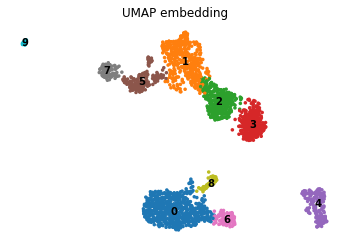

In [12]:
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

sc.tl.leiden(mdata, resolution=.3, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'], frameon=False, title="UMAP embedding", legend_loc="on data")

Add the clustering results to RNA and ATAC modality

In [13]:
# add the clustering results to chromvar modality
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['atac'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

Perform differential expression analysis

In [14]:
sc.tl.rank_genes_groups(mdata['rna'], 'leiden_wnn', method='wilcoxon')
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(10)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,0,1,2,3,4,5,6,7,8,9
0,DPYD,IL32,FHIT,LEF1,BANK1,CCL5,FCGR3A,GNLY,HLA-DPB1,PTPRS
1,PLXDC2,LTB,LEF1,BACH2,RALGPS2,NKG7,IFITM3,PRF1,HLA-DRA,TCF4
2,NEAT1,INPP4B,BCL11B,THEMIS,MS4A1,GZMA,LST1,NKG7,HLA-DPA1,LINC01374
3,LRMDA,EEF1A1,MALAT1,NELL2,AFF3,CST7,AIF1,CD247,CST3,IRF8
4,FCN1,IL7R,CAMK4,CD8B,PAX5,CTSW,SERPINA1,KLRD1,HLA-DRB1,ZFAT
5,JAK2,ITGB1,BACH2,PDE3B,CD74,IL32,TCF7L2,GZMA,CD74,FCHSD2
6,VCAN,TPT1,INPP4B,OXNAD1,CD79A,PRF1,FCER1G,CTSW,FLT3,LINC00996
7,SLC8A1,RPL41,OXNAD1,CD8A,LINC00926,A2M,PSAP,CST7,HLA-DRB5,CUX2
8,ARHGAP26,TRAC,TCF7,CCR7,IGHM,GNLY,IFI30,SPON2,HLA-DQA1,PLD4
9,DENND1A,RPS18,ANK3,TXK,CD79B,HCST,CST3,GZMB,GAPDH,CCDC50


### Motif analysis with pychromVAR

We first download the genome sequence, here hg38 is used.

In [15]:
pc.get_genome("hg38", output_dir="./")

Pre-processing data and perform motif matching

In [16]:
mdata['atac'].X = mdata['atac'].layers["counts"]

pc.add_peak_seq(mdata, genome_file="./hg38.fa", delimiter=":|-")
pc.add_gc_bias(mdata)
pc.get_bg_peaks(mdata)

# get motifs
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

pc.match_motif(mdata, motifs=motifs)

100%|██████████| 62871/62871 [00:47<00:00, 1320.46it/s]


In [17]:
mdata

MuData object with n_obs × n_vars = 2391 × 134920
  obs:	'leiden_wnn'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  obsm:	'X_umap', 'X_wnn_umap'
  obsp:	'wnn_distances', 'wnn_connectivities'
  2 modalities
    rna:	2391 x 21256
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_wnn'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'rank_genes_groups'
      obsm:	'X_pca'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    atac:	2391 x 62871
      obs:	'n_genes_by_counts', 'total_counts', 'leiden_wnn'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gc_bias'
      uns:	'lsi', 'neighbors', 'peak_seq', 'motif_name'
      obsm:	'X_lsi'
      varm:	'LSI', 'bg_peaks', 'motif_match'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

In [18]:
dev = pc.compute_deviations(mdata)
dev

2023-01-28 05:46:47 INFO     computing expectation reads per cell and peak...
2023-01-28 05:46:47 INFO     computing observed motif deviations...
2023-01-28 05:46:47 INFO     computing background deviations...


AnnData object with n_obs × n_vars = 2391 × 746

We can add it to mdata as another modality

In [19]:
mdata.mod['chromvar'] = dev
mdata.mod['chromvar'].raw = dev

Then we can analysis and visualize the motif variability as if they are RNA-seq data

In [20]:
# add the clustering results to chromvar modality
mdata['chromvar'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

We can perform differential analysis to identify marker motifs for each cluster

In [21]:
sc.tl.rank_genes_groups(mdata['chromvar'], 'leiden_wnn', method='wilcoxon', use_raw=True)

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Print the top10 motifs per cluster:

In [22]:
pd.DataFrame(mdata['chromvar'].uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8,9
0,MA0501.1.MAF::NFE2,MA0769.2.TCF7,MA0523.1.TCF7L2,MA0523.1.TCF7L2,MA0627.2.POU2F3,MA0800.1.EOMES,MA1111.1.NR2F2,MA0800.1.EOMES,MA0081.2.SPIB,MA1100.2.ASCL1
1,MA0150.2.Nfe2l2,MA1513.1.KLF15,MA0768.1.LEF1,MA0768.1.LEF1,MA1115.1.POU5F1,MA0690.1.TBX21,MA0687.1.SPIC,MA0688.1.TBX2,MA0080.5.SPI1,MA1635.1.BHLHE22(var.2)
2,MA0089.2.NFE2L1,MA0139.1.CTCF,MA0769.2.TCF7,MA0769.2.TCF7,MA0792.1.POU5F1B,MA0688.1.TBX2,MA0598.3.EHF,MA0690.1.TBX21,MA1508.1.IKZF1,MA0500.2.MYOG
3,MA0833.2.ATF4,MA0511.2.RUNX2,MA0632.2.TCFL5,MA0006.1.Ahr::Arnt,MA0507.1.POU2F2,MA0802.1.TBR1,MA0859.1.Rarg,MA0802.1.TBR1,MA1652.1.ZKSCAN5,MA0816.1.Ascl2
4,MA0838.1.CEBPG,MA0685.1.SP4,MA1421.1.TCF7L1,MA1421.1.TCF7L1,MA0785.1.POU2F1,MA0803.1.TBX15,MA0017.2.NR2F1,MA0803.1.TBX15,MA0598.3.EHF,MA1467.1.ATOH1(var.2)
5,MA0836.2.CEBPD,MA0481.3.FOXP1,MA0006.1.Ahr::Arnt,MA0442.2.SOX10,MA0789.1.POU3F4,MA1567.1.TBX6,MA0136.2.ELF5,MA0689.1.TBX20,MA0640.2.ELF3,MA0832.1.Tcf21
6,MA1633.1.BACH1,MA1683.1.FOXA3,MA1650.1.ZBTB14,MA0103.3.ZEB1,MA0784.1.POU1F1,MA0689.1.TBX20,MA1508.1.IKZF1,MA1567.1.TBX6,MA0687.1.SPIC,MA0048.2.NHLH1
7,MA0102.4.CEBPA,MA0768.1.LEF1,MA0732.1.EGR3,MA0139.1.CTCF,MA0787.1.POU3F2,MA1566.1.TBX3,MA0160.1.NR4A2,MA0805.1.TBX1,MA0645.1.ETV6,MA1472.1.BHLHA15(var.2)
8,MA1636.1.CEBPG(var.2),MA0042.2.FOXI1,MA0162.4.EGR1,MA0162.4.EGR1,MA0786.1.POU3F1,MA0805.1.TBX1,MA0080.5.SPI1,MA0801.1.MGA,MA0517.1.STAT1::STAT2,MA0698.1.ZBTB18
9,MA0496.3.MAFK,MA0850.1.FOXP3,MA1102.2.CTCFL,MA1102.2.CTCFL,MA0788.1.POU3F3,MA0801.1.MGA,MA0081.2.SPIB,MA1566.1.TBX3,MA0473.3.ELF1,MA0521.1.Tcf12


We can visualize the motif activity and gene expression at the same time.

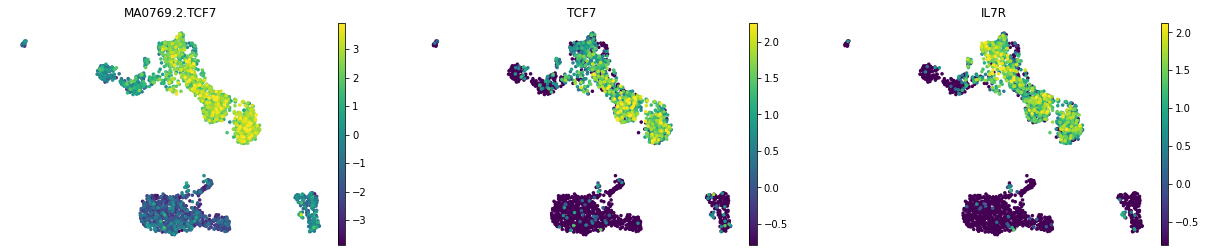

In [23]:
mu.pl.umap(mdata, color=['MA0769.2.TCF7', 'TCF7', "IL7R"], frameon=False, vmin='p1', vmax='p99')